## ML model testing

* logistic / multinomial logistic regression



In [1297]:
import pandas as pd
pd.set_option('display.max_columns',50)
#pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 50)
import numpy as np
from numpy import argmax
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_theme(style='whitegrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm
from sklearn.utils import resample
from sklearn import linear_model

from collections import Counter

In [1179]:
df = pd.read_csv('/Users/wjdol/Desktop/LighthouseLabs/Flight_delays/data/flights_complete_raw.csv', parse_dates=['fl_date'])

In [1180]:
df['fl_day'] = df['fl_date'].dt.weekday

In [1182]:
df.head()

mkt_unique_carrier origin dest  fl_day  week_num dep_time_of_day  \
0                 DL    FLL  ATL       6         2         evening   
1                 AA    DCA  DFW       0         3         morning   
2                 AA    ORD  IND       3         2       afternoon   
3                 UA    PIT  SFO       4         2       afternoon   
4                 DL    MSP  GFK       3         1         evening   

  arr_time_of_day  departures_performed    payload  passengers  \
0         evening                   3.0   118728.0       312.5   
1         morning                 111.5  4801900.0     14754.5   
2       afternoon                  23.0   349600.0      1603.0   
3         evening                   3.0   104033.0       429.0   
4       overnight                  29.0   565920.0      1876.0   

   distance_group  arr_delay  tdomt_gallons   tdomt_cost  AWND  PRCP  SNOW  \
0             2.0       -8.0    149458650.6  288453038.8  31.0  43.0   0.0   
1             3.0       75.0    163140817.6  265791415.6  30.0   0.0   3.0   
2             1.0       -7.0      6214610.8   12885113.2  20.0   0.0   0.0   
3             5.0       -7.0    115971276.2  193359267.6  29.0   0.0   0.0   
4             1.0      -15.0      6214610.8   12885113.2  33.0   0.0   0.0   

    SNWD   TAVG  
0    0.0  234.0  
1  250.0   -2.0  
2    0.0  -78.0  
3    0.0  -52.0  
4    0.0  -23.0

In [1181]:
# drop columns not used

df = df.drop(['Unnamed: 0', 'op_unique_carrier', 'origin_city', 'dest_city', 'fl_date', 'delay_binary','identifier', 'index', 'date_orig_id', 'weather_id', 'date_str', 'aircraft_type', 'distance', 'sdomt_gallons', 'sdomt_cost', 'freight', 'air_time'], axis=1)

In [1019]:
df[df['tdomt_gallons']==0]['mkt_unique_carrier'].unique()

array(['AA', 'UA', 'DL', 'AS'], dtype=object)

In [1183]:
df.loc[df['tdomt_gallons']==0, 'tdomt_gallons'] = np.mean(df['tdomt_gallons'])

In [1184]:
df.loc[df['tdomt_cost']==0,'tdomt_cost'] = np.mean(df['tdomt_cost'])

In [1185]:

df = df.drop(df[df['passengers']==0].index)

In [1186]:
dflreg = df.copy()

In [1187]:
# bins for numerical data

dflreg['SNWD'] = pd.cut(dflreg['SNWD'], bins=[0, 0.1, 60, 150, np.inf], labels=['0','1','2','3'], include_lowest=True)

dflreg['PRCP'] = pd.cut(dflreg['PRCP'], bins=[0, 0.1, 75, 250, np.inf], labels=['0','1','2','3'], include_lowest=True)

In [1188]:
# make bins for grouping

airlines_list = dict(pd.qcut(dflreg['mkt_unique_carrier'].value_counts(), q=[0, 0.45, 0.9, 1.0], labels=['1','2','3']))

origin_list = dict(pd.qcut(dflreg['origin'].value_counts(), q=[0, 0.25, 0.5, 1.0], labels=['1','2','3']))

dest_list = dict(pd.qcut(dflreg['dest'].value_counts(), q=[0, 0.25, 0.5, 1.0], labels=['1','2','3']))


In [1189]:
dflreg['mkt_unique_carrier'].replace(airlines_list, inplace=True)
dflreg['origin'].replace(origin_list, inplace=True)
dflreg['dest'].replace(dest_list, inplace=True)

In [719]:
# create list of value counts by columns

# identifier_count = Counter(dict(dflreg['identifier'].value_counts()))
# carrier_count = Counter(dict(dflreg['mkt_unique_carrier'].value_counts()))
# #originc_count = Counter(dict(dflreg['origin_city'].value_counts()))
# origin_count = Counter(dict(dflreg['origin'].value_counts()))
# #destc_count = Counter(dict(dflreg['dest_city'].value_counts()))
# dest_count = Counter(dict(dflreg['dest'].value_counts()))
# wkday_count = Counter(dict(dflreg['fl_day'].value_counts()))
# #type_count = Counter(dict(dflreg['aircraft_type'].value_counts()))
# payl_count = Counter(dict(dflreg['payload'].value_counts()))

In [1192]:
dflreg.head()

mkt_unique_carrier origin dest  fl_day  week_num dep_time_of_day  \
0                  2      3    3       6         2         evening   
1                  3      3    3       0         3         morning   
2                  3      3    3       3         2       afternoon   
3                  2      1    3       4         2       afternoon   
4                  2      3    2       3         1         evening   

  arr_time_of_day  departures_performed    payload  passengers  \
0         evening                   3.0   118728.0       312.5   
1         morning                 111.5  4801900.0     14754.5   
2       afternoon                  23.0   349600.0      1603.0   
3         evening                   3.0   104033.0       429.0   
4       overnight                  29.0   565920.0      1876.0   

   distance_group  arr_delay  tdomt_gallons   tdomt_cost  AWND PRCP  SNOW  \
0             2.0       -8.0    149458650.6  288453038.8  31.0    1   0.0   
1             3.0       75.0    163140817.6  265791415.6  30.0    0   3.0   
2             1.0       -7.0      6214610.8   12885113.2  20.0    0   0.0   
3             5.0       -7.0    115971276.2  193359267.6  29.0    0   0.0   
4             1.0      -15.0      6214610.8   12885113.2  33.0    0   0.0   

  SNWD   TAVG  costPerGallon  costPerPerson  gallonPerPerson  
0    0  234.0       1.929986  923049.724160    478267.681920  
1    3   -2.0       1.629215   18014.261114     11057.021085  
2    0  -78.0       2.073358    8038.124267      3876.862633  
3    0  -52.0       1.667303  450720.903497    270329.315152  
4    0  -23.0       2.073358    6868.397228      3312.692324

In [1191]:
# add new features based on fuel consumption, fuel cost, and passengers

dflreg['costPerGallon'] = dflreg['tdomt_cost']/dflreg['tdomt_gallons']
dflreg['costPerPerson'] = dflreg['tdomt_cost']/dflreg['passengers']
dflreg['gallonPerPerson'] = dflreg['tdomt_gallons']/dflreg['passengers']


In [645]:
# determine quartile splits

# top_carriers = top_categories(carrier_count, 0.90)
# top_dest = top_categories(dest_count, 0.5)
# top_origin = top_categories(origin_count, 0.5)
# top_identifier = top_categories(identifier_count, 0.05)

In [990]:
dflreg.head()

mkt_unique_carrier origin dest  fl_day  week_num dep_time_of_day  \
0                  2      3    3       6         2         evening   
1                  3      3    3       0         3         morning   
2                  3      3    3       3         2       afternoon   
3                  2      1    3       4         2       afternoon   
4                  2      3    2       3         1         evening   

  arr_time_of_day  departures_performed    payload  passengers  \
0         evening                   3.0   118728.0       312.5   
1         morning                 111.5  4801900.0     14754.5   
2       afternoon                  23.0   349600.0      1603.0   
3         evening                   3.0   104033.0       429.0   
4       overnight                  29.0   565920.0      1876.0   

   distance_group  delay_binary  tdomt_gallons   tdomt_cost  AWND PRCP  SNOW  \
0             2.0           0.0    149458650.6  288453038.8  31.0    1   0.0   
1             3.0           1.0    163140817.6  265791415.6  30.0    0   3.0   
2             1.0           0.0      6214610.8   12885113.2  20.0    0   0.0   
3             5.0           0.0    115971276.2  193359267.6  29.0    0   0.0   
4             1.0           0.0      6214610.8   12885113.2  33.0    0   0.0   

  SNWD   TAVG  costPerGallon  costPerPerson  gallonPerPerson  
0    0  234.0       1.929986  923049.724160    478267.681920  
1    3   -2.0       1.629215   18014.261114     11057.021085  
2    0  -78.0       2.073358    8038.124267      3876.862633  
3    0  -52.0       1.667303  450720.903497    270329.315152  
4    0  -23.0       2.073358    6868.397228      3312.692324

In [1193]:
dflreg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33503 entries, 0 to 33510
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   mkt_unique_carrier    33503 non-null  object  
 1   origin                33503 non-null  object  
 2   dest                  33503 non-null  object  
 3   fl_day                33503 non-null  int64   
 4   week_num              33503 non-null  int64   
 5   dep_time_of_day       33503 non-null  object  
 6   arr_time_of_day       33503 non-null  object  
 7   departures_performed  33503 non-null  float64 
 8   payload               33503 non-null  float64 
 9   passengers            33503 non-null  float64 
 10  distance_group        33503 non-null  float64 
 11  arr_delay             33503 non-null  float64 
 12  tdomt_gallons         33503 non-null  float64 
 13  tdomt_cost            33503 non-null  float64 
 14  AWND                  33503 non-null  float64 
 15  PR

In [1194]:
dflreg = pd.get_dummies(dflreg, columns=['dep_time_of_day','arr_time_of_day'], drop_first=True)

In [1195]:
# split features and target

y = dflreg['arr_delay']
X = dflreg.drop('arr_delay', axis=1)

In [1196]:
# train / test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [1197]:
num_X_train = X_train.select_dtypes(include=['float64'])
num_X_test = X_test.select_dtypes(include=['float64'])

In [977]:
num_X_train

fl_day  week_num  departures_performed    payload  passengers  \
10787       2         2                 214.0  7404400.0     22294.5   
6024        2         3                  30.0  1088100.0      2706.0   
5920        2         5                   1.0    34860.0       111.0   
6783        3         1                  38.0  1525000.0      4750.0   
9278        3         4                  79.5   749500.0      2910.5   
...       ...       ...                   ...        ...         ...   
14904       5         4                  27.5  1427600.0      4192.5   
12963       2         3                  35.0  1597300.0      5380.0   
17367       3         2                   3.0   118728.0       312.5   
1092        3         4                 128.0  2790784.0      8922.0   
9649        2         5                  39.0  1633381.0      4921.0   

       air_time  distance_group  tdomt_gallons   tdomt_cost  AWND  SNOW  \
10787   13395.0             1.0    156532592.0  293803944.4  18.0   0.0   
6024     3191.0             2.0    163140817.6  265791415.6  13.0   0.0   
5920      267.0             5.0     44216757.8   83115270.4  11.0   0.0   
6783     1466.0             1.0    156532592.0  293803944.4  47.0   0.0   
9278     4269.5             1.0        54337.0     144824.4  16.0   0.0   
...         ...             ...            ...          ...   ...   ...   
14904    7743.5             4.0    163140817.6  265791415.6  14.0   0.0   
12963   10172.0             6.0    163140817.6  265791415.6  99.0   0.0   
17367     255.0             2.0    149458650.6  288453038.8  45.0   0.0   
1092     7417.0             1.0      5327632.2    7937670.4  62.0   0.0   
9649     9181.0             4.0    115971276.2  193359267.6  68.0   0.0   

        TAVG  costPerGallon  costPerPerson  gallonPerPerson  \
10787  152.0       1.876951   13178.315028      7021.130413   
6024   137.0       1.629215   98222.991722     60288.550480   
5920    56.0       1.879723  748786.219820    398349.169369   
6783   110.0       1.876951   61853.461979     32954.229895   
9278    59.0       2.665300      49.759285        18.669301   
...      ...            ...            ...              ...   
14904    8.0       1.629215   63396.879094     38912.538485   
12963  124.0       1.629215   49403.608848     30323.572045   
17367  223.0       1.929986  923049.724160    478267.681920   
1092   154.0       1.489906     889.673885       597.134297   
9649  -259.0       1.667303   39292.677830     23566.607641   

       dep_time_of_day_evening  dep_time_of_day_morning  \
10787                        0                        0   
6024                         1                        0   
5920                         0                        0   
6783                         0                        1   
9278                         0                        1   
...                        ...                      ...   
14904                        0                        0   
12963                        0                        1   
17367                        0                        0   
1092                         1                        0   
9649                         0                        1   

       dep_time_of_day_overnight  arr_time_of_day_evening  \
10787                          0                        1   
6024                           0                        0   
5920                           0                        1   
6783                           0                        0   
9278                           0                        0   
...                          ...                      ...   
14904                          0                        1   
12963                          0                        0   
17367                          0                        1   
1092                           0                        1   
9649                           0                        0   

       arr_time_of_day_morning  arr_time_o

In [1198]:
# dflreg.isnull().sum()

In [1199]:
cat_X_train = X_train.select_dtypes(exclude=['float64'])
cat_X_test = X_test.select_dtypes(exclude=['float64'])

In [1200]:
scaler = StandardScaler()

scaler.fit(num_X_train)

scaled_X_train = scaler.transform(num_X_train)
scaled_X_test = scaler.transform(num_X_test)


In [1201]:
cat_X_train_f = cat_X_train.to_numpy()
cat_X_test_f = cat_X_test.to_numpy()

In [1202]:
X_train_f = np.hstack((cat_X_train_f, scaled_X_train))
X_test_f = np.hstack((cat_X_test_f, scaled_X_test))

In [1247]:
# create ensemble model

ens_0 = RandomForestRegressor(max_depth=10, n_jobs=-1)

ens_0.fit(X_train_f, y_train)

RandomForestRegressor(max_depth=10, n_jobs=-1)

In [1248]:
ens_0.score(X_test_f, y_test)

0.00024385231900958537

In [1250]:
ens_0.decision_path(X_test_f)

(<6701x81042 sparse matrix of type '<class 'numpy.int64'>'
 	with 7359856 stored elements in Compressed Sparse Row format>,
 array([    0,   903,  1734,  2543,  3320,  4079,  4722,  5541,  6332,
         7083,  7878,  8757,  9446, 10163, 10904, 11705, 12522, 13379,
        13944, 14803, 15678, 16497, 17518, 18197, 19066, 19925, 20784,
        21659, 22508, 23267, 23980, 24823, 25640, 26569, 27518, 28299,
        29188, 30147, 31044, 31631, 32416, 33109, 33966, 34723, 35694,
        36597, 37406, 38123, 38960, 39745, 40644, 41423, 42352, 43135,
        43940, 44803, 45706, 46573, 47380, 48241, 49068, 49873, 50672,
        51471, 52270, 53147, 54022, 54895, 55674, 56615, 57328, 58101,
        58872, 59695, 60572, 61265, 62024, 62899, 63712, 64547, 65172,
        66009, 66880, 67579, 68202, 68831, 69594, 70469, 71108, 71837,
        72558, 73483, 74368, 75163, 75926, 76815, 77722, 78481, 79364,
        80211, 81042], dtype=int32))

In [1251]:
# ens_0.coef_

In [1214]:
coeffs = np.hstack((ens_0.intercept_, ens_0.coef_))
coeffs_tbl = pd.DataFrame(data={'variable': ['intercept'] + list(X.columns) , 'coefficient': coeffs})

<BarContainer object of 25 artists>

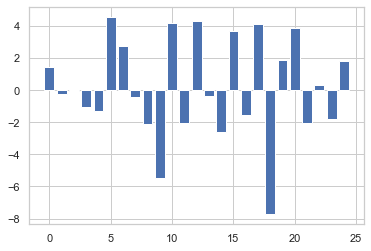

In [1215]:
plt.bar([x for x in range(len(ens_0.coef_))], ens_0.coef_)

In [1216]:
coeffs_tbl.sort_values(by='coefficient', ascending=False)

variable  coefficient
0                   intercept     4.894405
6        departures_performed     4.577657
13                       PRCP     4.331385
11                 tdomt_cost     4.218508
18              costPerPerson     4.108742
21    dep_time_of_day_morning     3.878090
16                       TAVG     3.716991
7                     payload     2.752106
20    dep_time_of_day_evening     1.911286
25  arr_time_of_day_overnight     1.796018
1          mkt_unique_carrier     1.474341
23    arr_time_of_day_evening     0.347943
3                        dest    -0.075438
2                      origin    -0.226127
14                       SNOW    -0.358874
8                  passengers    -0.443718
4                      fl_day    -1.022605
5                    week_num    -1.273177
17              costPerGallon    -1.525649
24    arr_time_of_day_morning    -1.769620
12                       AWND    -2.034122
22  dep_time_of_day_overnight    -2.041614
9              distance_group    -2.116212
15                       SNWD    -2.611431
10              tdomt_gallons    -5.472480
19            gallonPerPerson    -7.744079

In [1288]:
# params = {}

ens_1 = RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 50)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8]

# Method of selecting samples for training each tree
bootstrap = [True]



params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

reg_cv = RandomizedSearchCV(ens_1, param_distributions=params, n_iter=5, cv=3, n_jobs=-1, scoring='r2')


In [1289]:
reg_cv.fit(X_train_f, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1000, 1040, 1081, 1122,
                                                         1163, 1204, 1244, 1285,
                                                         1326, 1367, 1408, 1448,
                                                         1489, 1530, 1571, 1612,
                                                         1653, 1693, 1734, 1775,
                            

In [1290]:
reg_cv.best_params_

{'n_estimators': 2673,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [1291]:
reg_cv.best_estimator_

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=2673)

In [1296]:
reg_cv.best_score_

0.056863517602431246

In [1299]:
Pkl_Filename = 'Pickle_RFReg_model.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(reg_cv, file)

In [1292]:
reg_cv.cv_results_

{'mean_fit_time': array([110.70482477, 198.10736473, 225.93396187, 179.69483511,
        137.2455461 ]),
 'std_fit_time': array([ 2.72673551,  1.28835478,  3.87498468, 14.6053607 ,  6.93639389]),
 'mean_score_time': array([ 5.76797915,  9.28265921, 10.22500062,  6.79633387,  5.1833361 ]),
 'std_score_time': array([0.50560136, 0.64799735, 0.78150705, 0.87647011, 0.19368775]),
 'param_n_estimators': masked_array(data=[1571, 1979, 2673, 1816, 1734],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[5, 5, 10, 2, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[8, 2, 4, 2, 2],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt'],
              m

<BarContainer object of 25 artists>

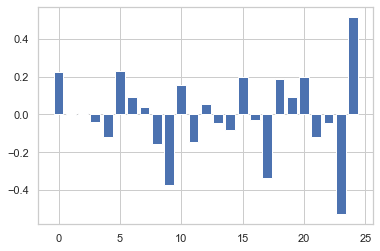

In [1172]:
# display feature importance

# model ens_0:

importance_0 = ens_0.coef_[0]
   
    
coefficients = np.hstack((ens_0.intercept_, ens_0.coef_[0]))
coeffs_df = pd.DataFrame(data={'variable': ['intercept'] + list(X), 'coefficient': coefficients})
    
plt.bar([x for x in range(len(importance_0))], importance_0)



In [1173]:
coeffs_df.sort_values(by='coefficient', ascending=False)

variable  coefficient
25  arr_time_of_day_overnight     0.515902
6        departures_performed     0.226833
1          mkt_unique_carrier     0.223454
16                       TAVG     0.197201
21    dep_time_of_day_morning     0.195865
19            gallonPerPerson     0.184297
11                 tdomt_cost     0.152776
20    dep_time_of_day_evening     0.094008
7                     payload     0.092794
13                       PRCP     0.053579
8                  passengers     0.040305
3                        dest     0.006563
2                      origin    -0.000732
17              costPerGallon    -0.027584
4                      fl_day    -0.041881
14                       SNOW    -0.045269
23    arr_time_of_day_evening    -0.047299
15                       SNWD    -0.081471
5                    week_num    -0.117452
22  dep_time_of_day_overnight    -0.118229
12                       AWND    -0.148038
9              distance_group    -0.157760
18              costPerPerson    -0.338247
10              tdomt_gallons    -0.374651
24    arr_time_of_day_morning    -0.528769
0                   intercept    -0.827132